<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Training_optic_Discs_in_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

Kaggle has a large competition of Diabetic Retinopathy detection which can be found here:
https://www.kaggle.com/c/diabetic-retinopathy-detection/

Their dataset consists in 35126 images labeled from 0 to 4 according to the degree of Retinopathy.
An analysis of the data is provided in this notebook.

In [1]:
!rm -rf sample_data
!nvidia-smi

Sun Feb 21 06:11:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies

In [2]:
from IPython.display import clear_output

!pip install torch==1.7.1+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install efficientnet_pytorch
clear_output(wait=False)

## Load data from local drive


In [3]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ETdcB8GscyBAkhUFvNMzpoUBLLgg7ej9Q3t4rK_bR8ngSA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait=False)
print("Data Downloaded")

Data Downloaded


In [4]:
!rm checkpoint*

rm: cannot remove 'checkpoint*': No such file or directory


In [5]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Neovessels",File) for File in os.listdir("./OpticDiscs/Neovessels") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Good images",File) for File in os.listdir("./OpticDiscs/Good images") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "Good" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/Good images/4270_left.jpeg,1
1,./OpticDiscs/Good images/26079_left.jpeg,1
2,./OpticDiscs/Good images/4998_right.jpeg,1
3,./OpticDiscs/Good images/21026_right.jpeg,1
4,./OpticDiscs/Good images/40631_left.jpeg,1


In [6]:
len(data)

374

#### Split data

In [7]:
from sklearn.model_selection import train_test_split

Train,Validation = train_test_split(data,test_size = 0.40,random_state = 65)
X_train = Train['imageFilename']
y_train = Train['class']
#Split data
X_validation, X_test, y_validation, y_test = train_test_split(Validation['imageFilename'], Validation['class'], test_size=0.50, random_state=65)


In [8]:
print("Datos de entrenamiento:")
print(y_train.value_counts())
print("Datos de validación:")
print(y_validation.value_counts())
print("Datos de test:")
print(y_test.value_counts())

Datos de entrenamiento:
0    119
1    105
Name: class, dtype: int64
Datos de validación:
1    44
0    31
Name: class, dtype: int64
Datos de test:
1    38
0    37
Name: class, dtype: int64


In [9]:
test_data = pd.DataFrame({'image':X_test,'class':y_test})
test_data['image'] = test_data['image'].apply(lambda x : x.split('/')[-1])
test_data.head()

,image,class
198,37829_left.jpeg,0
9,29712_left.jpeg,1
132,32085_right.jpeg,1
259,11896_left.jpeg,0
208,21096_left.jpeg,0


In [10]:
test_data.to_csv('test_data.csv',index=False)

## Definition of the model

In [11]:
import torchvision.models as models
import torch
network_name = 'resnet18'
model = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [12]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
## Change efficientnet final layer
model.fc = torch.nn.Linear(in_features=512,out_features=2,bias = True)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11177538

In [15]:
from torchvision.transforms import Resize,ToTensor,Compose,Normalize
from torchvision.transforms import RandomHorizontalFlip,RandomVerticalFlip,RandomRotation,ColorJitter,RandomResizedCrop,RandomPerspective,GaussianBlur
from PIL import Image

transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),
                      RandomRotation(180),ColorJitter(0.5,0.5,0.5),
                      RandomResizedCrop((224 ,224), scale=(0.7, 1.2)),
                      RandomPerspective(),
                      GaussianBlur((3,3))]) # Transformations for the training images

composed = Compose([Resize(224), # Resize to a fit size for efficientnet
                    ToTensor(),  # Convert into sensor
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

### Training parameters

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
seed = 17
torch.manual_seed(seed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [17]:
try:
    model = torch.load('./checkpoint_b0_11.ph', map_location=device)
except:
    print("No Checkpoint loaded")

No Checkpoint loaded


In [18]:
classes = {0:[0,0,0,0,1],
           1:[0,0,0,1,0],
           2:[0,0,1,0,0],
           3:[0,1,0,0,0],
           4:[1,0,0,0,0]}

In [19]:
from tqdm import tqdm
import random
random.seed(seed)

epochs = 100
batch_size = 1  # I will use batch size of 1 to keep the ratio of each image

TRAINING_acc = []
VALIDATION_acc = []
BEST_val_acc = 0.0

for epoch in range(epochs):
    
    indexes = [idx for idx in range(len(X_train))]
    pbar = tqdm( range(len(X_train)//batch_size),ncols = 100)
    running_loss = 0.0
    running_acc = 0.0
    t = 0

    for step in pbar:
        # Load data
        idx = random.sample(indexes,batch_size)
        X = X_train.iloc[idx]
        y = y_train.iloc[idx]

        # Remove indexes
        [indexes.remove(i) for i in idx]

        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = transforms(image)
            P = composed(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += batch_size

        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y_true).cpu().detach().numpy()
        acc = torch.sum(preds == y_true).cpu().detach().numpy()/batch_size;
        pbar.set_description("Epoch: {} Accuracy: {:0.5f} Loss: {:0.5f} ".format(epoch+1,running_acc/t,loss.item()))
    #Validation
    TRAINING_acc.append(running_acc/t)
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for point in range(len(X_validation)//batch_size):
        with torch.no_grad():

            X = X_validation.iloc[point*batch_size:(point+1)*batch_size]
            y = y_validation.iloc[point*batch_size:(point+1)*batch_size]


            # Load images
            try:
                images = [Image.open(File) for File in X]
            except:
                continue
            # Load y_true
            y_true = torch.LongTensor([c for c in y]).to(device)
            
            # Convert images to tensor
            x_batch = torch.FloatTensor().to(device)
            for image in images:
                P = composed(image).unsqueeze(0).to(device)
                x_batch = torch.cat((x_batch,P))

            
            outputs = model(x_batch)
            loss = criterion(outputs, y_true)
            val_loss += loss.item()
            t += batch_size
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == y_true).cpu().detach().numpy()
    VALIDATION_acc.append(val_acc/t)
    print("Validation -- Accuracy: {:0.5f} Loss: {:0.5f} \n".format(val_acc/t,loss.item()))
    if val_acc/t > BEST_val_acc:
        try:
            torch.save(model,"/content/checkpoint_{}_{}_{:0.5f}.ph".format(network_name,epoch+1,val_acc/t))
            BEST_val_acc = val_acc/t
        except:
            continue

Epoch: 2 Accuracy: 1.00000 Loss: 0.68875 :   1%|▏                   | 2/224 [00:00<00:11, 19.40it/s]

Validation -- Accuracy: 0.41333 Loss: 0.70493 



Epoch: 3 Accuracy: 0.00000 Loss: 0.74467 :   1%|▏                   | 2/224 [00:00<00:16, 13.32it/s]

Validation -- Accuracy: 0.41333 Loss: 0.71641 



Epoch: 4 Accuracy: 0.66667 Loss: 0.62864 :   1%|▏                   | 2/224 [00:00<00:13, 16.11it/s]

Validation -- Accuracy: 0.41333 Loss: 0.72414 



Epoch: 5 Accuracy: 1.00000 Loss: 0.65054 :   1%|▏                   | 2/224 [00:00<00:19, 11.43it/s]

Validation -- Accuracy: 0.41333 Loss: 0.73017 



Epoch: 6 Accuracy: 0.50000 Loss: 0.61276 :   1%|▏                   | 2/224 [00:00<00:11, 19.57it/s]

Validation -- Accuracy: 0.41333 Loss: 0.70417 



Epoch: 7 Accuracy: 0.50000 Loss: 0.62202 :   1%|▏                   | 2/224 [00:00<00:16, 13.77it/s]

Validation -- Accuracy: 0.41333 Loss: 0.76933 



Epoch: 8 Accuracy: 0.66667 Loss: 0.67504 :   1%|▏                   | 2/224 [00:00<00:11, 18.53it/s]

Validation -- Accuracy: 0.41333 Loss: 0.72696 



Epoch: 9 Accuracy: 0.66667 Loss: 0.68001 :   1%|▏                   | 2/224 [00:00<00:13, 16.95it/s]

Validation -- Accuracy: 0.41333 Loss: 0.70184 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.42667 Loss: 0.71299 



Epoch: 11 Accuracy: 1.00000 Loss: 0.66372 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.62667 Loss: 0.67319 



Epoch: 12 Accuracy: 1.00000 Loss: 0.45345 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.72000 Loss: 0.66843 



Epoch: 13 Accuracy: 1.00000 Loss: 0.52168 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.73333 Loss: 0.59646 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.74667 Loss: 0.50725 



Epoch: 15 Accuracy: 1.00000 Loss: 0.20636 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.76000 Loss: 0.46255 



Epoch: 16 Accuracy: 1.00000 Loss: 0.26776 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.78667 Loss: 0.41991 



Epoch: 17 Accuracy: 1.00000 Loss: 0.27528 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.78667 Loss: 0.32214 



Epoch: 18 Accuracy: 1.00000 Loss: 0.42088 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.85333 Loss: 0.36180 



Epoch: 19 Accuracy: 1.00000 Loss: 0.20710 :   1%|▏                  | 2/224 [00:00<00:14, 14.96it/s]

Validation -- Accuracy: 0.84000 Loss: 0.42932 



Epoch: 20 Accuracy: 1.00000 Loss: 0.38620 :   1%|▏                  | 2/224 [00:00<00:15, 14.45it/s]

Validation -- Accuracy: 0.85333 Loss: 0.31320 



Epoch: 21 Accuracy: 0.50000 Loss: 0.08045 :   1%|▏                  | 2/224 [00:00<00:15, 14.18it/s]

Validation -- Accuracy: 0.84000 Loss: 0.27496 



Epoch: 22 Accuracy: 1.00000 Loss: 0.21797 :   1%|▏                  | 2/224 [00:00<00:15, 14.41it/s]

Validation -- Accuracy: 0.82667 Loss: 0.18208 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.82667 Loss: 0.20922 



Epoch: 24 Accuracy: 1.00000 Loss: 0.18428 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88000 Loss: 0.19156 



Epoch: 25 Accuracy: 1.00000 Loss: 0.10516 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.85333 Loss: 0.16823 



Epoch: 26 Accuracy: 1.00000 Loss: 0.07658 :   1%|▏                  | 2/224 [00:00<00:13, 16.89it/s]

Validation -- Accuracy: 0.85333 Loss: 0.16464 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89333 Loss: 0.17981 



Epoch: 28 Accuracy: 1.00000 Loss: 0.07881 :   0%|                   | 1/224 [00:00<00:23,  9.44it/s]

Validation -- Accuracy: 0.86667 Loss: 0.13285 



Epoch: 29 Accuracy: 1.00000 Loss: 0.19597 :   1%|▏                  | 2/224 [00:00<00:16, 13.11it/s]

Validation -- Accuracy: 0.89333 Loss: 0.13630 



Epoch: 30 Accuracy: 1.00000 Loss: 0.07000 :   1%|▏                  | 2/224 [00:00<00:18, 12.15it/s]

Validation -- Accuracy: 0.88000 Loss: 0.14561 



Epoch: 31 Accuracy: 0.66667 Loss: 0.09954 :   1%|▎                  | 3/224 [00:00<00:12, 18.14it/s]

Validation -- Accuracy: 0.89333 Loss: 0.15898 



Epoch: 32 Accuracy: 1.00000 Loss: 0.05994 :   1%|▏                  | 2/224 [00:00<00:18, 11.80it/s]

Validation -- Accuracy: 0.86667 Loss: 0.20870 



Epoch: 33 Accuracy: 1.00000 Loss: 0.05034 :   1%|▎                  | 3/224 [00:00<00:11, 19.40it/s]

Validation -- Accuracy: 0.88000 Loss: 0.11281 



Epoch: 34 Accuracy: 1.00000 Loss: 0.12203 :   1%|▏                  | 2/224 [00:00<00:11, 18.89it/s]

Validation -- Accuracy: 0.86667 Loss: 0.11529 



Epoch: 35 Accuracy: 1.00000 Loss: 0.13635 :   1%|▎                  | 3/224 [00:00<00:09, 22.70it/s]

Validation -- Accuracy: 0.86667 Loss: 0.10049 



Epoch: 36 Accuracy: 1.00000 Loss: 0.25434 :   1%|▏                  | 2/224 [00:00<00:18, 12.29it/s]

Validation -- Accuracy: 0.86667 Loss: 0.08740 



Epoch: 37 Accuracy: 1.00000 Loss: 0.10495 :   1%|▏                  | 2/224 [00:00<00:14, 15.67it/s]

Validation -- Accuracy: 0.85333 Loss: 0.08597 



Epoch: 38 Accuracy: 1.00000 Loss: 0.03698 :   1%|▎                  | 3/224 [00:00<00:09, 22.12it/s]

Validation -- Accuracy: 0.88000 Loss: 0.09195 



Epoch: 39 Accuracy: 1.00000 Loss: 0.06168 :   1%|▏                  | 2/224 [00:00<00:14, 15.19it/s]

Validation -- Accuracy: 0.89333 Loss: 0.08274 



Epoch: 40 Accuracy: 0.66667 Loss: 0.10526 :   1%|▏                  | 2/224 [00:00<00:12, 17.98it/s]

Validation -- Accuracy: 0.89333 Loss: 0.08192 



Epoch: 41 Accuracy: 1.00000 Loss: 0.13447 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.85333 Loss: 0.07991 



Epoch: 42 Accuracy: 1.00000 Loss: 0.15360 :   1%|▏                  | 2/224 [00:00<00:15, 14.27it/s]

Validation -- Accuracy: 0.88000 Loss: 0.09094 



Epoch: 43 Accuracy: 1.00000 Loss: 0.05506 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.90667 Loss: 0.09795 



Epoch: 44 Accuracy: 1.00000 Loss: 0.03163 :   1%|▏                  | 2/224 [00:00<00:11, 18.86it/s]

Validation -- Accuracy: 0.88000 Loss: 0.07255 



Epoch: 45 Accuracy: 1.00000 Loss: 0.05652 :   1%|▏                  | 2/224 [00:00<00:14, 14.91it/s]

Validation -- Accuracy: 0.89333 Loss: 0.06698 



Epoch: 46 Accuracy: 1.00000 Loss: 0.05081 :   1%|▏                  | 2/224 [00:00<00:12, 17.83it/s]

Validation -- Accuracy: 0.88000 Loss: 0.08134 



Epoch: 47 Accuracy: 0.66667 Loss: 0.02773 :   1%|▎                  | 3/224 [00:00<00:10, 20.53it/s]

Validation -- Accuracy: 0.85333 Loss: 0.06539 



Epoch: 48 Accuracy: 1.00000 Loss: 0.11928 :   1%|▏                  | 2/224 [00:00<00:17, 12.76it/s]

Validation -- Accuracy: 0.89333 Loss: 0.06544 



Epoch: 49 Accuracy: 1.00000 Loss: 0.02077 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92000 Loss: 0.06663 



Epoch: 50 Accuracy: 1.00000 Loss: 0.03487 :   1%|▏                  | 2/224 [00:00<00:13, 16.49it/s]

Validation -- Accuracy: 0.85333 Loss: 0.06307 



Epoch: 51 Accuracy: 1.00000 Loss: 0.06003 :   1%|▏                  | 2/224 [00:00<00:12, 17.31it/s]

Validation -- Accuracy: 0.92000 Loss: 0.09793 



Epoch: 52 Accuracy: 1.00000 Loss: 0.02543 :   1%|▎                  | 3/224 [00:00<00:11, 19.32it/s]

Validation -- Accuracy: 0.85333 Loss: 0.06924 



Epoch: 53 Accuracy: 1.00000 Loss: 0.02464 :   1%|▏                  | 2/224 [00:00<00:12, 17.86it/s]

Validation -- Accuracy: 0.89333 Loss: 0.06472 



Epoch: 54 Accuracy: 1.00000 Loss: 0.02132 :   1%|▏                  | 2/224 [00:00<00:13, 16.56it/s]

Validation -- Accuracy: 0.88000 Loss: 0.05881 



Epoch: 55 Accuracy: 1.00000 Loss: 0.03213 :   1%|▎                  | 3/224 [00:00<00:11, 19.16it/s]

Validation -- Accuracy: 0.85333 Loss: 0.04472 



Epoch: 56 Accuracy: 1.00000 Loss: 0.01762 :   1%|▏                  | 2/224 [00:00<00:19, 11.67it/s]

Validation -- Accuracy: 0.88000 Loss: 0.05066 



Epoch: 57 Accuracy: 1.00000 Loss: 0.11940 :   1%|▏                  | 2/224 [00:00<00:11, 19.28it/s]

Validation -- Accuracy: 0.85333 Loss: 0.06197 



Epoch: 58 Accuracy: 1.00000 Loss: 0.21813 :   1%|▏                  | 2/224 [00:00<00:17, 12.36it/s]

Validation -- Accuracy: 0.90667 Loss: 0.08223 



Epoch: 59 Accuracy: 1.00000 Loss: 0.01798 :   1%|▏                  | 2/224 [00:00<00:16, 13.71it/s]

Validation -- Accuracy: 0.84000 Loss: 0.05016 



Epoch: 60 Accuracy: 1.00000 Loss: 0.01807 :   1%|▏                  | 2/224 [00:00<00:12, 17.94it/s]

Validation -- Accuracy: 0.89333 Loss: 0.05658 



Epoch: 61 Accuracy: 1.00000 Loss: 0.67543 :   1%|▏                  | 2/224 [00:00<00:13, 16.10it/s]

Validation -- Accuracy: 0.92000 Loss: 0.04978 



Epoch: 62 Accuracy: 1.00000 Loss: 0.05247 :   1%|▏                  | 2/224 [00:00<00:15, 13.93it/s]

Validation -- Accuracy: 0.89333 Loss: 0.06458 



Epoch: 63 Accuracy: 1.00000 Loss: 0.01418 :   1%|▏                  | 2/224 [00:00<00:16, 13.57it/s]

Validation -- Accuracy: 0.92000 Loss: 0.11266 



Epoch: 64 Accuracy: 1.00000 Loss: 0.04591 :   1%|▏                  | 2/224 [00:00<00:17, 13.04it/s]

Validation -- Accuracy: 0.89333 Loss: 0.05798 



Epoch: 65 Accuracy: 0.66667 Loss: 0.05525 :   1%|▎                  | 3/224 [00:00<00:11, 19.05it/s]

Validation -- Accuracy: 0.89333 Loss: 0.05189 



Epoch: 66 Accuracy: 1.00000 Loss: 0.01431 :   1%|▏                  | 2/224 [00:00<00:16, 13.54it/s]

Validation -- Accuracy: 0.92000 Loss: 0.04925 



Epoch: 67 Accuracy: 1.00000 Loss: 0.11723 :   1%|▏                  | 2/224 [00:00<00:12, 17.58it/s]

Validation -- Accuracy: 0.90667 Loss: 0.05270 



Epoch: 68 Accuracy: 1.00000 Loss: 0.01726 :   1%|▏                  | 2/224 [00:00<00:19, 11.35it/s]

Validation -- Accuracy: 0.89333 Loss: 0.03974 



Epoch: 69 Accuracy: 1.00000 Loss: 0.06309 :   1%|▏                  | 2/224 [00:00<00:13, 16.58it/s]

Validation -- Accuracy: 0.89333 Loss: 0.04736 



Epoch: 70 Accuracy: 1.00000 Loss: 0.01446 :   1%|▏                  | 2/224 [00:00<00:15, 13.96it/s]

Validation -- Accuracy: 0.88000 Loss: 0.03546 



Epoch: 71 Accuracy: 1.00000 Loss: 0.01749 :   1%|▏                  | 2/224 [00:00<00:17, 13.00it/s]

Validation -- Accuracy: 0.89333 Loss: 0.04038 



Epoch: 72 Accuracy: 1.00000 Loss: 0.01366 :   1%|▏                  | 2/224 [00:00<00:17, 12.46it/s]

Validation -- Accuracy: 0.92000 Loss: 0.04221 



Epoch: 73 Accuracy: 1.00000 Loss: 0.01966 :   1%|▏                  | 2/224 [00:00<00:14, 15.41it/s]

Validation -- Accuracy: 0.92000 Loss: 0.05682 



Epoch: 74 Accuracy: 0.50000 Loss: 0.01633 :   1%|▏                  | 2/224 [00:00<00:14, 15.36it/s]

Validation -- Accuracy: 0.90667 Loss: 0.06616 



Epoch: 75 Accuracy: 1.00000 Loss: 0.02008 :   1%|▏                  | 2/224 [00:00<00:12, 17.72it/s]

Validation -- Accuracy: 0.88000 Loss: 0.05640 



Epoch: 76 Accuracy: 1.00000 Loss: 0.02076 :   1%|▏                  | 2/224 [00:00<00:14, 15.20it/s]

Validation -- Accuracy: 0.88000 Loss: 0.04771 



Epoch: 77 Accuracy: 1.00000 Loss: 0.01497 :   0%|                   | 1/224 [00:00<00:44,  5.04it/s]

Validation -- Accuracy: 0.90667 Loss: 0.04551 



Epoch: 78 Accuracy: 1.00000 Loss: 0.01115 :   1%|▏                  | 2/224 [00:00<00:12, 18.09it/s]

Validation -- Accuracy: 0.90667 Loss: 0.04708 



Epoch: 79 Accuracy: 1.00000 Loss: 0.02501 :   1%|▎                  | 3/224 [00:00<00:10, 20.27it/s]

Validation -- Accuracy: 0.89333 Loss: 0.04563 



Epoch: 80 Accuracy: 1.00000 Loss: 0.52369 :   1%|▎                  | 3/224 [00:00<00:11, 19.04it/s]

Validation -- Accuracy: 0.88000 Loss: 0.03481 



Epoch: 81 Accuracy: 1.00000 Loss: 0.02023 :   1%|▏                  | 2/224 [00:00<00:16, 13.39it/s]

Validation -- Accuracy: 0.89333 Loss: 0.04062 



Epoch: 82 Accuracy: 1.00000 Loss: 0.13816 :   1%|▎                  | 3/224 [00:00<00:12, 17.39it/s]

Validation -- Accuracy: 0.89333 Loss: 0.03588 



Epoch: 83 Accuracy: 1.00000 Loss: 0.00911 :   1%|▏                  | 2/224 [00:00<00:14, 15.75it/s]

Validation -- Accuracy: 0.92000 Loss: 0.04808 



Epoch: 84 Accuracy: 1.00000 Loss: 0.02146 :   1%|▎                  | 3/224 [00:00<00:08, 24.78it/s]

Validation -- Accuracy: 0.85333 Loss: 0.02872 



Epoch: 85 Accuracy: 1.00000 Loss: 0.01655 :   1%|▏                  | 2/224 [00:00<00:11, 19.41it/s]

Validation -- Accuracy: 0.89333 Loss: 0.03475 



Epoch: 86 Accuracy: 1.00000 Loss: 0.01065 :   1%|▏                  | 2/224 [00:00<00:19, 11.54it/s]

Validation -- Accuracy: 0.88000 Loss: 0.03298 



Epoch: 87 Accuracy: 1.00000 Loss: 0.02684 :   1%|▏                  | 2/224 [00:00<00:15, 14.52it/s]

Validation -- Accuracy: 0.89333 Loss: 0.03153 



Epoch: 88 Accuracy: 1.00000 Loss: 0.28802 :   0%|                   | 1/224 [00:00<00:26,  8.27it/s]

Validation -- Accuracy: 0.92000 Loss: 0.03229 



Epoch: 89 Accuracy: 0.33333 Loss: 1.52839 :   1%|▏                  | 2/224 [00:00<00:14, 14.95it/s]

Validation -- Accuracy: 0.92000 Loss: 0.02337 



Epoch: 90 Accuracy: 1.00000 Loss: 0.08224 :   1%|▏                  | 2/224 [00:00<00:12, 17.88it/s]

Validation -- Accuracy: 0.90667 Loss: 0.02022 



Epoch: 91 Accuracy: 1.00000 Loss: 0.01207 :   1%|▏                  | 2/224 [00:00<00:17, 12.65it/s]

Validation -- Accuracy: 0.92000 Loss: 0.03290 



Epoch: 92 Accuracy: 1.00000 Loss: 0.01015 :   1%|▏                  | 2/224 [00:00<00:17, 12.83it/s]

Validation -- Accuracy: 0.90667 Loss: 0.02668 



Epoch: 93 Accuracy: 0.66667 Loss: 0.02644 :   1%|▏                  | 2/224 [00:00<00:13, 16.94it/s]

Validation -- Accuracy: 0.89333 Loss: 0.03497 



Epoch: 94 Accuracy: 1.00000 Loss: 0.01151 :   1%|▎                  | 3/224 [00:00<00:11, 19.60it/s]

Validation -- Accuracy: 0.84000 Loss: 0.02532 



Epoch: 95 Accuracy: 1.00000 Loss: 0.00976 :   0%|                           | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93333 Loss: 0.03096 



Epoch: 96 Accuracy: 1.00000 Loss: 0.03582 :   1%|▏                  | 2/224 [00:00<00:12, 17.35it/s]

Validation -- Accuracy: 0.92000 Loss: 0.02770 



Epoch: 97 Accuracy: 1.00000 Loss: 0.01238 :   1%|▏                  | 2/224 [00:00<00:15, 14.61it/s]

Validation -- Accuracy: 0.93333 Loss: 0.03285 



Epoch: 98 Accuracy: 1.00000 Loss: 0.01844 :   1%|▏                  | 2/224 [00:00<00:18, 12.29it/s]

Validation -- Accuracy: 0.92000 Loss: 0.02752 



Epoch: 99 Accuracy: 1.00000 Loss: 0.00815 :   1%|▏                  | 2/224 [00:00<00:17, 12.71it/s]

Validation -- Accuracy: 0.90667 Loss: 0.03101 



Epoch: 100 Accuracy: 1.00000 Loss: 0.11530 :   1%|▏                 | 2/224 [00:00<00:11, 19.45it/s]

Validation -- Accuracy: 0.92000 Loss: 0.03670 



Epoch: 100 Accuracy: 0.95536 Loss: 0.15888 : 100%|████████████████| 224/224 [00:14<00:00, 15.05it/s]


Validation -- Accuracy: 0.92000 Loss: 0.03096 



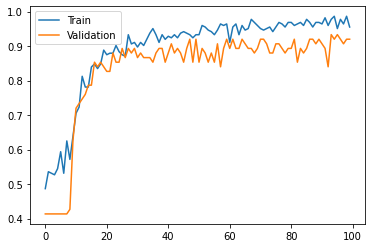

In [20]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

In [21]:
!ls

checkpoint_resnet18_10_0.62667.ph  checkpoint_resnet18_23_0.88000.ph
checkpoint_resnet18_1_0.41333.ph   checkpoint_resnet18_26_0.89333.ph
checkpoint_resnet18_11_0.72000.ph  checkpoint_resnet18_42_0.90667.ph
checkpoint_resnet18_12_0.73333.ph  checkpoint_resnet18_48_0.92000.ph
checkpoint_resnet18_13_0.74667.ph  checkpoint_resnet18_9_0.42667.ph
checkpoint_resnet18_14_0.76000.ph  checkpoint_resnet18_94_0.93333.ph
checkpoint_resnet18_15_0.78667.ph  OpticDiscs
checkpoint_resnet18_17_0.85333.ph  test_data.csv


In [ ]:
torch.save(model,"checkpoint.ph")

In [ ]:
for c in y:
  print(c)

1


## Evaluation

In [35]:
model = torch.load('checkpoint_resnet18_23_0.88000.ph')

In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [37]:
predicted = []
true_values = []
all_predicted = []
all_true = []
for point in range(len(X_test)//batch_size):
    with torch.no_grad():

        X = X_test.iloc[point*batch_size:(point+1)*batch_size]
        y = y_test.iloc[point*batch_size:(point+1)*batch_size]

        true_values.append(y.values)
        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = composed(image).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        all_predicted.append(outputs.cpu().detach().numpy()[0][1])
        all_true.append(y_true.cpu().detach().numpy()[0])
        
        _, preds = torch.max(outputs, 1)
        predicted.append(preds)

In [38]:
true_values = np.array(true_values).reshape(-1)
dummy = torch.FloatTensor().to(device)
for tensor in predicted:
    dummy = torch.cat((dummy,tensor))
predicted = dummy.view(-1).cpu().numpy()

In [39]:
confusion_matrix(true_values, predicted)

array([[29,  8],
       [ 4, 34]])

0.9139402560455191


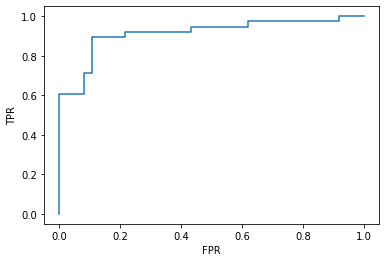

In [40]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

ns_fpr, ns_tpr, _ = roc_curve(all_true, all_predicted)
plt.plot(ns_fpr,ns_tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
print(roc_auc_score(all_true, all_predicted))

In [28]:
!mkdir Results
roc_data = pd.DataFrame(data = {"ns_fpr":ns_fpr,"ns_tpr":ns_tpr})
roc_data.to_csv("./Results/"+network_name+".csv")